In [34]:
import pandas as pd
import numpy as np
from snownlp import SnowNLP
from sklearn.feature_extraction.text import  CountVectorizer
import re
import jieba

In [35]:
# 读取数据并进行处理
datav1 = pd.read_excel("origin_data.xlsx")
datav1.head()

# 修改格式
## drop无关的列
datav2 = datav1.drop(['图片', 'index_projectstep__2hsqs', '信息1', '信息3', '信息5'], axis=1)
datav2.head()
## 修改列名
datav2.columns = ['title', 'Achievement_rate', 'amount', 'people']
datav2.to_csv('CFdatav2.csv')
datav2.head()

,title,Achievement_rate,amount,people
0,大自然的香水茶，栀子花香,118%,11871.0,49
1,无言SC-K506W智能空气炸锅,105%,10512.0,48
2,智能可烧水电热保温杯 冬天出门如“饮随行,117%,11781.0,119
3,三围暖脚器 给你从脚到全身的温暖,103%,10385.0,73
4,快充充电宝移动电源 大容量大功率超级快充,103%,10388.0,106


In [36]:
# 处理文本数据
datav2 = pd.read_csv('CFdatav2.csv')
def get_keyword(text):
    s = SnowNLP(text)
    return ' '.join(s.keywords(limit=5))
#get_keyword("大自然的香水茶，栀子花香")
datav2['keyword'] = datav2['title'].apply(get_keyword)

In [37]:
datav2.head()

,Unnamed: 0,title,Achievement_rate,amount,people,keyword
0,0,大自然的香水茶，栀子花香,118%,11871.0,49,茶 香水 大自然 花 香
1,1,无言SC-K506W智能空气炸锅,105%,10512.0,48,空气 智能 炸 SC-K506W 锅
2,2,智能可烧水电热保温杯 冬天出门如“饮随行,117%,11781.0,119,杯 保温 冬天 电热 出门
3,3,三围暖脚器 给你从脚到全身的温暖,103%,10385.0,73,脚器 暖 全身 脚到 三围
4,4,快充充电宝移动电源 大容量大功率超级快充,103%,10388.0,106,充 大 容量 电源 充电


In [38]:
#向量化
count_vect = CountVectorizer()
words_vect = count_vect.fit_transform(list(datav2.keyword))
words_input = words_vect.todense().A
length = words_input[0].shape[0]
length
#print(words_input.tolist())

11755

In [39]:
datav2['words_vect'] = words_input.tolist()
datav2.head()

datav3 = pd.DataFrame(words_input)
datav3['amount'] = datav2['amount']
min = datav3['amount'].min()
max = datav3['amount'].max()
#temp = (datav3['amount']-min)/(max-min)
#datav3 = datav3.drop(['amount'],axis=1)
#datav3['amount'] = temp;
datav3.head()

,0,1,2,3,4,5,6,7,8,9,...,11746,11747,11748,11749,11750,11751,11752,11753,11754,amount
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11871.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10512.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11781.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10385.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10388.0


In [40]:
import pathlib
import matplotlib.pyplot as plt

In [41]:
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [42]:
train, test = train_test_split(datav3, test_size=0.2)
train_label = train.pop('amount')
test_label = test.pop('amount')

In [43]:
train.head()
train.keys()

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       11745, 11746, 11747, 11748, 11749, 11750, 11751, 11752, 11753, 11754],
      dtype='object', length=11755)

In [58]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[len(train.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.1)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [59]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               1504768   
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,513,089
Trainable params: 1,513,089
Non-trainable params: 0
_________________________________________________________________


In [64]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  train, train_label,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


..

In [61]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,1.692457e+12,386080.50000,1.692457e+12,1.649550e+12,410290.81250,1.649550e+12,0
1,1.691897e+12,385395.21875,1.691897e+12,1.648445e+12,409041.93750,1.648445e+12,1
2,1.690263e+12,383359.06250,1.690263e+12,1.645902e+12,406188.65625,1.645902e+12,2
3,1.686938e+12,379400.62500,1.686938e+12,1.641370e+12,401241.00000,1.641370e+12,3
4,1.681576e+12,373539.68750,1.681576e+12,1.634311e+12,394599.62500,1.634311e+12,4


In [62]:
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,1.383545e+12,411581.31250,1.383545e+12,1.397261e+12,511823.65625,1.397261e+12,95
96,1.381840e+12,412767.06250,1.381840e+12,1.397677e+12,513715.25000,1.397677e+12,96
97,1.380573e+12,412825.68750,1.380573e+12,1.398066e+12,514531.28125,1.398066e+12,97
98,1.379466e+12,410943.09375,1.379466e+12,1.398276e+12,514583.78125,1.398276e+12,98
99,1.377933e+12,411513.56250,1.377933e+12,1.398735e+12,516030.71875,1.398735e+12,99


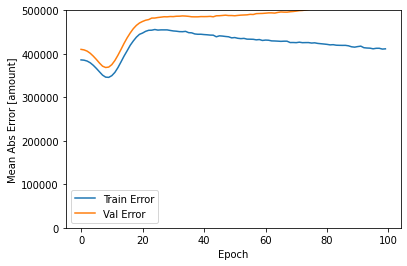

In [63]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [amount]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,500000])
  plt.legend()

  plt.show()


plot_history(history)

In [ ]:
model = build_model()

# patience 值用来检查改进 epochs 的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train, train_label, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)